Imports needen only in Colab

In [0]:
!pip install -q tensorflow-gpu==2.0.0-beta0

import os
os.chdir("/content/snr")
# from google.colab import drive
# drive.mount('/content/drive/')
# try:
# os.chdir("drive/My Drive/snr/project")
# except FileNotFoundError:
#     pass
!git clone https://gitlab.com/0darnox0/snr.git


Cloning into 'snr'...
remote: Enumerating objects: 102, done.
remote: Counting objects: 100% (102/102), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 102 (delta 47), reused 59 (delta 31)
Receiving objects: 100% (102/102), 898.72 MiB | 34.35 MiB/s, done.
Resolving deltas: 100% (47/47), done.
Checking out files: 100% (35/35), done.


All other imports

In [0]:
import os

import tensorflow as tf
from tensorflow import keras

AUTOTUNE = tf.data.experimental.AUTOTUNE

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from definitions import *
from preprocessing import load_datasets, time_footprint, load_labels_datasets

# Load datasets

In [0]:
train_ds, test_ds, val_ds = load_datasets()

W0611 01:59:59.889398 139665337898880 deprecation.py:323] From /content/snr/preprocessing.py:56: shuffle_and_repeat (from tensorflow.python.data.experimental.ops.shuffle_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Dataset.shuffle(buffer_size, seed)` followed by `tf.data.Dataset.repeat(count)`. Static tf.data optimizations will take care of using the fused implementation.


# Create model no. 1_1 (learning rate = 1e-4)

In [0]:
ALPHA = 1.0  # controls the width of the network
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape = IMG_SHAPE,
                                               include_top = False, 
                                               alpha       = ALPHA,
                                               weights     = 'imagenet')

In [0]:
base_model.trainable = False

In [0]:
model1_1 = tf.keras.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(NUMBER_OF_LABELS, activation='softmax')
])

In [0]:
base_learning_rate = 1.0e-4
model1_1.compile(optimizer = tf.keras.optimizers.Adam(lr=base_learning_rate), 
              loss      = 'sparse_categorical_crossentropy', 
              metrics   = ['accuracy'])

In [0]:
model1_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 106)               135786    
Total params: 2,393,770
Trainable params: 135,786
Non-trainable params: 2,257,984
_________________________________________________________________


# Test model no. 1_1

In [0]:
#additional packages added
time_fp = time_footprint()
from __future__ import absolute_import, division, print_function, unicode_literals
import math

#checkpoint delcaration
weights_dir = '/content/snr/models/task_1_2019-06-09_23-40-28'
latest = tf.train.latest_checkpoint(weights_dir)

#loading model
model1_1.load_weights(latest)
model1_1.summary()

#fetching data
train_ds, test_ds, val_ds = load_datasets()
train_labels_ds, test_labels_ds, val_labels_ds = load_labels_datasets()
tf.executing_eagerly()

#real labels for test dataset
real_test_ds_lables = [x.numpy() for x in test_labels_ds]

#computing accuracy
loss1_1, acc1_1 = model1_1.evaluate(test_ds, steps = 106)


#preparing predictions
predictions = model1_1.predict(test_ds, verbose=1, steps = None)


n = 106 # number of classes
cmc_rate= [0 for i in range(0,106)] 

#algorithm for computing rate for each topN classification
#step no. 1: Count rate for top1
#step no. 2: Count deltas for each next topN classifiaction
i = 0
for x in predictions:
    temp = []
    temp = x.tolist()

    for a in range(0,n):
      maxIndex = temp.index(max(temp))
      temp[maxIndex] = 0
      if real_test_ds_lables[i] == maxIndex:
        cmc_rate[a] += 1

    i+=1
      
#counting relative value of topN error
cmc_rate = [i/len(predictions) for i in cmc_rate]
real_crc_rate1_1 = [0 for i in range(0,106)]
real_crc_rate1_1[0]  = cmc_rate[0]

#summing deltas in order to count topN rate for N>1 
for i in range(1,106):
    real_crc_rate1_1[i] = real_crc_rate1_1[i-1] + cmc_rate[i]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 106)               135786    
Total params: 2,393,770
Trainable params: 135,786
Non-trainable params: 2,257,984
_________________________________________________________________
106/106 [==============================] - 29s 274ms/step - loss: 1.2989 - accuracy: 0.6879
    120/Unknown - 32s 270ms/step

#Display evaluation for model no. 1_1



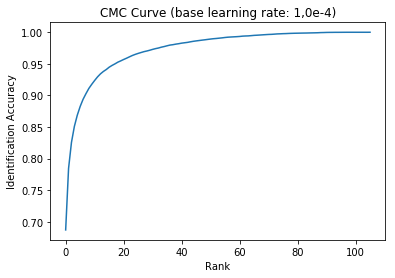


Restored model, accuracy: 68.79%

TOP1 error rate: 31.29%

TOP5 error rate: 13.14%


In [0]:
print("")
import matplotlib.pyplot as plt
plt.plot(real_crc_rate1_1)
plt.ylabel('Identification Accuracy')
plt.xlabel('Rank')
plt.title('CMC Curve (base learning rate: 1,0e-4)')
plt.show()

print("")
print("Restored model, accuracy: {:5.2f}%".format(100*acc1_1))
print("")
print("TOP1 error rate: {:5.2f}%".format(100*(1.0 - real_crc_rate1_1[0])))
print("")
print("TOP5 error rate: {:5.2f}%".format(100*(1.0 - real_crc_rate1_1[4])))

# Create model no. 1_2 (learning rate = 2.5e-5)

In [0]:
model1_2 = tf.keras.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(NUMBER_OF_LABELS, activation='softmax')
])

In [0]:
base_learning_rate = 2.5e-5
model1_2.compile(optimizer = tf.keras.optimizers.Adam(lr=base_learning_rate), 
              loss      = 'sparse_categorical_crossentropy', 
              metrics   = ['accuracy'])

In [0]:
model1_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 106)               135786    
Total params: 2,393,770
Trainable params: 135,786
Non-trainable params: 2,257,984
_________________________________________________________________


# Test model no. 1_2

In [0]:
#additional packages added
time_fp = time_footprint()
from __future__ import absolute_import, division, print_function, unicode_literals
import math

#checkpoint delcaration
weights_dir = '/content/snr/models/task_1_2019-06-10_16-59-57'
latest = tf.train.latest_checkpoint(weights_dir)

#loading model
model1_2.load_weights(latest)
model1_2.summary()

#fetching data
train_ds, test_ds, val_ds = load_datasets()
train_labels_ds, test_labels_ds, val_labels_ds = load_labels_datasets()
tf.executing_eagerly()

#real labels for test dataset
real_test_ds_lables = [x.numpy() for x in test_labels_ds]

#computing accuracy
loss1_2, acc1_2 = model1_2.evaluate(test_ds, steps = 106)


#preparing predictions
predictions = model1_2.predict(test_ds, verbose=1, steps = None)


n = 106 # number of classes
cmc_rate= [0 for i in range(0,106)] 

#algorithm for computing rate for each topN classification
#step no. 1: Count rate for top1
#step no. 2: Count deltas for each next topN classifiaction
i = 0
for x in predictions:
    temp = []
    temp = x.tolist()

    for a in range(0,n):
      maxIndex = temp.index(max(temp))
      temp[maxIndex] = 0
      if real_test_ds_lables[i] == maxIndex:
        cmc_rate[a] += 1

    i+=1
      
#counting relative value of topN error
cmc_rate = [i/len(predictions) for i in cmc_rate]
real_crc_rate1_2 = [0 for i in range(0,106)]
real_crc_rate1_2[0]  = cmc_rate[0]

#summing deltas in order to count topN rate for N>1 
for i in range(1,106):
    real_crc_rate1_2[i] = real_crc_rate1_2[i-1] + cmc_rate[i]


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 106)               135786    
Total params: 2,393,770
Trainable params: 135,786
Non-trainable params: 2,257,984
_________________________________________________________________
106/106 [==============================] - 30s 281ms/step - loss: 1.3102 - accuracy: 0.6872
    120/Unknown - 34s 284ms/step

#Display evaluation for model no. 1_2

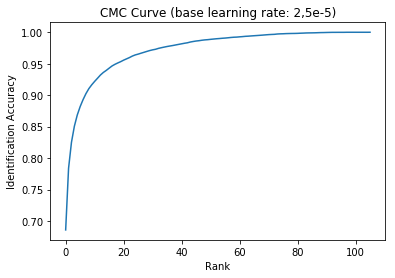


Restored model, accuracy: 68.72%

TOP1 error rate: 31.42%

TOP5 error rate: 13.16%


In [0]:
print("")
import matplotlib.pyplot as plt
plt.plot(real_crc_rate1_2)
plt.ylabel('Identification Accuracy')
plt.xlabel('Rank')
plt.title('CMC Curve (base learning rate: 2,5e-5)')
plt.show()

print("")
print("Restored model, accuracy: {:5.2f}%".format(100*acc1_2))
print("")
print("TOP1 error rate: {:5.2f}%".format(100*(1.0 - real_crc_rate1_2[0])))
print("")
print("TOP5 error rate: {:5.2f}%".format(100*(1.0 - real_crc_rate1_2[4])))

# Create model no. 2_1 (learning base = 2.5e-4)

In [0]:
ALPHA = 1.0  # controls the width of the network
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape = IMG_SHAPE,
                                               include_top = False, 
                                               alpha       = ALPHA,
                                               weights     = 'imagenet')

**MobileNetV2** model's last 3 layers are: **Conv2D**, **BatchNormalization**, **ReLU**. So to make last convolution layer trainable we need to set all layers, expect last 3, as non-trainable.

In [0]:
base_model.trainable = True


In [0]:
model2_1 = tf.keras.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(NUMBER_OF_LABELS, activation='softmax')
])

In [0]:
base_learning_rate = 2.5e-4
model2_1.compile(optimizer = tf.keras.optimizers.Adam(lr=base_learning_rate), 
              loss      = 'sparse_categorical_crossentropy', 
              metrics   = ['accuracy'])

In [0]:
model2_1.summary()

# Test model no. 2_1

In [0]:
#additional packages added
time_fp = time_footprint()
from __future__ import absolute_import, division, print_function, unicode_literals
import math

#checkpoint delcaration
weights_dir = '/content/snr/models/task_2_2019-06-09_23-52-13'
latest = tf.train.latest_checkpoint(weights_dir)

#loading model
model2_1.load_weights(latest)
model2_1.summary()

#fetching data
train_ds, test_ds, val_ds = load_datasets()
train_labels_ds, test_labels_ds, val_labels_ds = load_labels_datasets()
tf.executing_eagerly()

#real labels for test dataset
real_test_ds_lables = [x.numpy() for x in test_labels_ds]

#computing accuracy
loss2_1, acc2_1 = model2_1.evaluate(test_ds, steps = 106)


#preparing predictions
predictions = model2_1.predict(test_ds, verbose=1, steps = None)


n = 106 # number of classes
cmc_rate= [0 for i in range(0,106)] 

#algorithm for computing rate for each topN classification
#step no. 1: Count rate for top1
#step no. 2: Count deltas for each next topN classifiaction
i = 0
for x in predictions:
    temp = []
    temp = x.tolist()

    for a in range(0,n):
      maxIndex = temp.index(max(temp))
      temp[maxIndex] = 0
      if real_test_ds_lables[i] == maxIndex:
        cmc_rate[a] += 1

    i+=1
      
#counting relative value of topN error
cmc_rate = [i/len(predictions) for i in cmc_rate]
real_crc_rate2_1 = [0 for i in range(0,106)]
real_crc_rate2_1[0]  = cmc_rate[0]

#summing deltas in order to count topN rate for N>1 
for i in range(1,106):
    real_crc_rate2_1[i] = real_crc_rate2_1[i-1] + cmc_rate[i]

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 106)               135786    
Total params: 2,393,770
Trainable params: 2,359,658
Non-trainable params: 34,112
_________________________________________________________________
106/106 [==============================] - 30s 285ms/step - loss: 1.1473 - accuracy: 0.7409
    120/Unknown - 34s 284ms/step

#Display evaluation for model no. 2_1


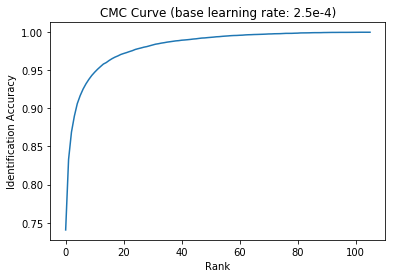


Restored model, accuracy: 74.09%

TOP1 error rate: 25.95%

TOP5 error rate:  9.38%


In [0]:
print("")
import matplotlib.pyplot as plt
plt.plot(real_crc_rate2_1)
plt.ylabel('Identification Accuracy')
plt.xlabel('Rank')
plt.title('CMC Curve (base learning rate: 2.5e-4)')
plt.show()

print("")
print("Restored model, accuracy: {:5.2f}%".format(100*acc2_1))
print("")
print("TOP1 error rate: {:5.2f}%".format(100*(1.0 - real_crc_rate2_1[0])))
print("")
print("TOP5 error rate: {:5.2f}%".format(100*(1.0 - real_crc_rate2_1[4])))

# Create model no. 2_2 (learning rate = 2.5e-5)

In [0]:
model2_2 = tf.keras.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(NUMBER_OF_LABELS, activation='softmax')
])

In [0]:
base_learning_rate = 2.5e-5
model2_2.compile(optimizer = tf.keras.optimizers.Adam(lr=base_learning_rate), 
              loss      = 'sparse_categorical_crossentropy', 
              metrics   = ['accuracy'])

In [0]:
model2_2.summary()

# Test model no. 2_2

In [0]:
#additional packages added
time_fp = time_footprint()
from __future__ import absolute_import, division, print_function, unicode_literals
import math

#checkpoint delcaration
weights_dir = '/content/snr/models/task_2_2019-06-10_12-56-48'
latest = tf.train.latest_checkpoint(weights_dir)

#loading model
model2_2.load_weights(latest)
model2_2.summary()

#fetching data
train_ds, test_ds, val_ds = load_datasets()
train_labels_ds, test_labels_ds, val_labels_ds = load_labels_datasets()
tf.executing_eagerly()

#real labels for test dataset
real_test_ds_lables = [x.numpy() for x in test_labels_ds]

#computing accuracy
loss2_2, acc2_2 = model2_2.evaluate(test_ds, steps = 106)


#preparing predictions
predictions = model2_2.predict(test_ds, verbose=1, steps = None)


n = 106 # number of classes
cmc_rate= [0 for i in range(0,106)] 

#algorithm for computing rate for each topN classification
#step no. 1: Count rate for top1
#step no. 2: Count deltas for each next topN classifiaction
i = 0
for x in predictions:
    temp = []
    temp = x.tolist()

    for a in range(0,n):
      maxIndex = temp.index(max(temp))
      temp[maxIndex] = 0
      if real_test_ds_lables[i] == maxIndex:
        cmc_rate[a] += 1

    i+=1
      
#counting relative value of topN error
cmc_rate = [i/len(predictions) for i in cmc_rate]
real_crc_rate2_2 = [0 for i in range(0,106)]
real_crc_rate2_2[0]  = cmc_rate[0]

#summing deltas in order to count topN rate for N>1 
for i in range(1,106):
    real_crc_rate2_2[i] = real_crc_rate2_2[i-1] + cmc_rate[i]


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 106)               135786    
Total params: 2,393,770
Trainable params: 2,359,658
Non-trainable params: 34,112
_________________________________________________________________
106/106 [==============================] - 30s 283ms/step - loss: 1.0237 - accuracy: 0.7441
    120/Unknown - 34s 282ms/step

#Display evaluation for model no. 2_2

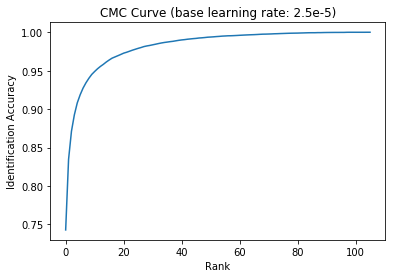


Restored model, accuracy: 74.41%

TOP1 error rate: 25.72%

TOP5 error rate:  9.19%


In [0]:
print("")
import matplotlib.pyplot as plt
plt.plot(real_crc_rate2_2)
plt.ylabel('Identification Accuracy')
plt.xlabel('Rank')
plt.title('CMC Curve (base learning rate: 2.5e-5)')
plt.show()

print("")
print("Restored model, accuracy: {:5.2f}%".format(100*acc2_2))
print("")
print("TOP1 error rate: {:5.2f}%".format(100*(1.0 - real_crc_rate2_2[0])))
print("")
print("TOP5 error rate: {:5.2f}%".format(100*(1.0 - real_crc_rate2_2[4])))

# Create model 3a_1

In [0]:
ALPHA = 1.0  # controls the width of the network
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape = IMG_SHAPE,
                                               include_top = False, 
                                               alpha       = ALPHA,
                                               weights     = 'imagenet')

In [0]:
base_model.summary()

In [0]:
base_model.trainable = True

In [0]:
model3a_1 = tf.keras.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(NUMBER_OF_LABELS, activation='softmax')
])

In [0]:
base_learning_rate = 2.5e-5
model3a_1.compile(optimizer = tf.keras.optimizers.Adam(lr=base_learning_rate), 
              loss      = 'sparse_categorical_crossentropy', 
              metrics   = ['accuracy'])

In [0]:
model3a_1.summary()

# Test model 3a_1

In [0]:
#additional packages added
time_fp = time_footprint()
from __future__ import absolute_import, division, print_function, unicode_literals
import math

#checkpoint delcaration
weights_dir = '/content/snr/models/task_3_a_2019-06-09_23-49-47'
latest = tf.train.latest_checkpoint(weights_dir)

#loading model
model3a_1.load_weights(latest)
model3a_1.summary()

#fetching data
train_ds, test_ds, val_ds = load_datasets()
train_labels_ds, test_labels_ds, val_labels_ds = load_labels_datasets()
tf.executing_eagerly()

#real labels for test dataset
real_test_ds_lables = [x.numpy() for x in test_labels_ds]

#computing accuracy
loss3a_1, acc3a_1 = model3a_1.evaluate(test_ds, steps = 106)


#preparing predictions
predictions = model3a_1.predict(test_ds, verbose=1, steps = None)


n = 106 # number of classes
cmc_rate= [0 for i in range(0,106)] 

#algorithm for computing rate for each topN classification
#step no. 1: Count rate for top1
#step no. 2: Count deltas for each next topN classifiaction
i = 0
for x in predictions:
    temp = []
    temp = x.tolist()

    for a in range(0,n):
      maxIndex = temp.index(max(temp))
      temp[maxIndex] = 0
      if real_test_ds_lables[i] == maxIndex:
        cmc_rate[a] += 1

    i+=1
      
#counting relative value of topN error
cmc_rate = [i/len(predictions) for i in cmc_rate]
real_crc_rate3a_1 = [0 for i in range(0,106)]
real_crc_rate3a_1[0]  = cmc_rate[0]

#summing deltas in order to count topN rate for N>1 
for i in range(1,106):
    real_crc_rate3a_1[i] = real_crc_rate3a_1[i-1] + cmc_rate[i]





Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 106)               135786    
Total params: 2,393,770
Trainable params: 2,359,658
Non-trainable params: 34,112
_________________________________________________________________
106/106 [==============================] - 30s 280ms/step - loss: 0.7283 - accuracy: 0.8196
    120/Unknown - 34s 285ms/step

#Dispaly evaluation 3a_1



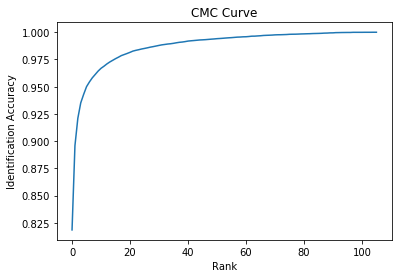


Restored model, accuracy: 81.96%

TOP1 error rate: 18.15%

TOP5 error rate:  5.71%


In [0]:
print("")
import matplotlib.pyplot as plt
plt.plot(real_crc_rate3a_1)
plt.ylabel('Identification Accuracy')
plt.xlabel('Rank')
plt.title('CMC Curve')
plt.show()

print("")
print("Restored model, accuracy: {:5.2f}%".format(100*acc3a_1))
print("")
print("TOP1 error rate: {:5.2f}%".format(100*(1.0 - real_crc_rate3a_1[0])))
print("")
print("TOP5 error rate: {:5.2f}%".format(100*(1.0 - real_crc_rate3a_1[4])))

## Create simpler model 3b_1

In [0]:
simpler_base_model = tf.keras.applications.MobileNetV2(input_shape = IMG_SHAPE,
                                                       include_top = False, 
                                                       alpha       = ALPHA,
                                                       weights     = 'imagenet')

In [0]:
last_layer_old = simpler_base_model.get_layer('block_15_project_BN').output
x = keras.layers.Conv2D(**simpler_base_model.get_layer('Conv_1').get_config())(last_layer_old)
x = keras.layers.BatchNormalization(**simpler_base_model.get_layer('Conv_1_bn').get_config())(x)
last_layer_new = keras.layers.ReLU(**simpler_base_model.get_layer('out_relu').get_config())(x)

In [0]:
simpler_base_model = tf.keras.Model(inputs = simpler_base_model.layers[0].input, outputs = last_layer_new, name='Simpler')

In [0]:
simpler_base_model.summary()

In [0]:
simpler_base_model.trainable = True

In [0]:
model3b_1 = tf.keras.Sequential([
    simpler_base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(NUMBER_OF_LABELS, activation='softmax')
])

In [0]:
base_learning_rate = 2.5e-5
model3b_1.compile(optimizer = tf.keras.optimizers.Adam(lr=base_learning_rate), 
                      loss      = 'sparse_categorical_crossentropy', 
                      metrics   = ['accuracy'])

In [0]:
model3b_1.summary()

# Test simpler model 3b_1

In [0]:
#additional packages added
time_fp = time_footprint()
from __future__ import absolute_import, division, print_function, unicode_literals
import math

#checkpoint delcaration
weights_dir = '/content/snr/models/task_3_b_2019-06-09_23-51-11'
latest = tf.train.latest_checkpoint(weights_dir)

#loading model
model3b_1.load_weights(latest)
model3b_1.summary()

#fetching data
train_ds, test_ds, val_ds = load_datasets()
train_labels_ds, test_labels_ds, val_labels_ds = load_labels_datasets()
tf.executing_eagerly()

#real labels for test dataset
real_test_ds_lables = [x.numpy() for x in test_labels_ds]

#computing accuracy
loss3b_1, acc3b_1 = model3b_1.evaluate(test_ds, steps = 106)


#preparing predictions
predictions = model3b_1.predict(test_ds, verbose=1, steps = None)


n = 106 # number of classes
cmc_rate= [0 for i in range(0,106)] 

#algorithm for computing rate for each topN classification
#step no. 1: Count rate for top1
#step no. 2: Count deltas for each next topN classifiaction
i = 0
for x in predictions:
    temp = []
    temp = x.tolist()

    for a in range(0,n):
      maxIndex = temp.index(max(temp))
      temp[maxIndex] = 0
      if real_test_ds_lables[i] == maxIndex:
        cmc_rate[a] += 1

    i+=1
      
#counting relative value of topN error
cmc_rate = [i/len(predictions) for i in cmc_rate]
real_crc_rate3b_1 = [0 for i in range(0,106)]
real_crc_rate3b_1[0]  = cmc_rate[0]

#summing deltas in order to count topN rate for N>1 
for i in range(1,106):
    real_crc_rate3b_1[i] = real_crc_rate3b_1[i-1] + cmc_rate[i]

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Simpler (Model)              (None, 6, 6, 1280)        1574784   
_________________________________________________________________
global_average_pooling2d_5 ( (None, 1280)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 106)               135786    
Total params: 1,710,570
Trainable params: 1,680,938
Non-trainable params: 29,632
_________________________________________________________________
106/106 [==============================] - 28s 261ms/step - loss: 0.6059 - accuracy: 0.8501
    120/Unknown - 30s 252ms/step

#Display evaluation 3b_1

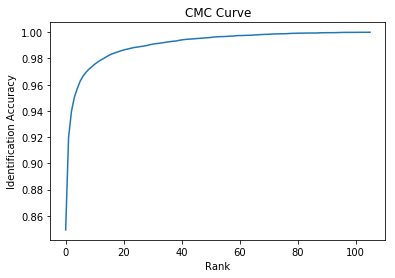


Restored model, accuracy: 85.01%

TOP1 error rate: 15.08%

TOP5 error rate:  4.30%


In [0]:
print("")
import matplotlib.pyplot as plt
plt.plot(real_crc_rate3b_1)
plt.ylabel('Identification Accuracy')
plt.xlabel('Rank')
plt.title('CMC Curve')
plt.show()

print("")
print("Restored model, accuracy: {:5.2f}%".format(100*acc3b_1))
print("")
print("TOP1 error rate: {:5.2f}%".format(100*(1.0 - real_crc_rate3b_1[0])))
print("")
print("TOP5 error rate: {:5.2f}%".format(100*(1.0 - real_crc_rate3b_1[4])))

#Comparison of models

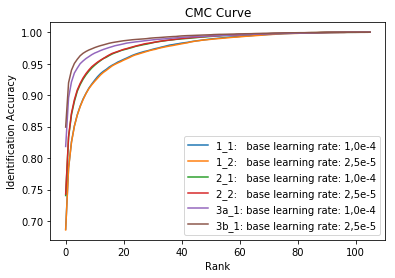

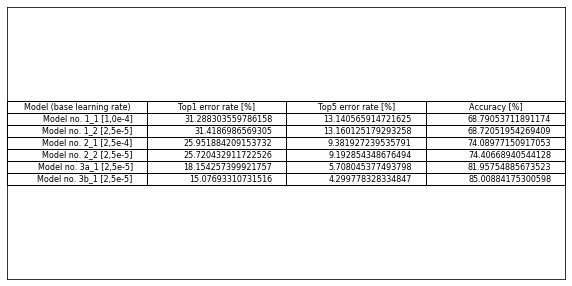

W0611 02:42:42.297938 139665337898880 legend.py:1289] No handles with labels found to put in legend.


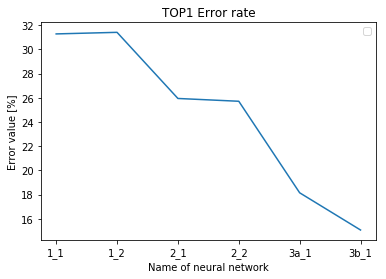

W0611 02:42:42.486697 139665337898880 legend.py:1289] No handles with labels found to put in legend.


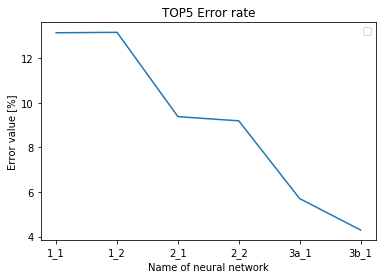

W0611 02:42:42.648936 139665337898880 legend.py:1289] No handles with labels found to put in legend.


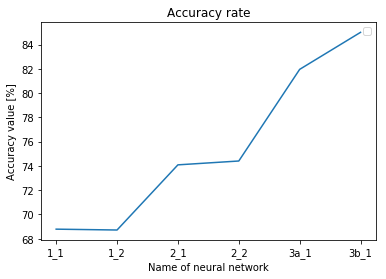

In [63]:
plt.plot(real_crc_rate1_1, label='1_1:   base learning rate: 1,0e-4')
plt.plot(real_crc_rate1_2, label='1_2:   base learning rate: 2,5e-5')
plt.plot(real_crc_rate2_1, label='2_1:   base learning rate: 1,0e-4')
plt.plot(real_crc_rate2_2, label='2_2:   base learning rate: 2,5e-5')
plt.plot(real_crc_rate3a_1, label='3a_1: base learning rate: 1,0e-4')
plt.plot(real_crc_rate3b_1, label='3b_1: base learning rate: 2,5e-5')
plt.legend(loc='best')
plt.ylabel('Identification Accuracy')
plt.xlabel('Rank')
plt.title('CMC Curve')
plt.show()



fig=plt.figure(figsize=[10,5])

ax = fig.add_subplot(111)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
colLabels=("Model (base learning rate)", "Top1 error rate [%]", "Top5 error rate [%]", "Accuracy [%]")
the_table = ax.table(cellText=[
    ["Model no. 1_1 [1,0e-4]",100*(1.0 - real_crc_rate1_1[0]),100*(1.0 - real_crc_rate1_1[4]), acc1_1*100],
    ["Model no. 1_2 [2,5e-5]",100*(1.0 - real_crc_rate1_2[0]),100*(1.0 - real_crc_rate1_2[4]), acc1_2*100],
    ["Model no. 2_1 [2,5e-4]",100*(1.0 - real_crc_rate2_1[0]),100*(1.0 - real_crc_rate2_1[4]), acc2_1*100],
    ["Model no. 2_2 [2,5e-5]",100*(1.0 - real_crc_rate2_2[0]),100*(1.0 - real_crc_rate2_2[4]), acc2_2*100],
    ["Model no. 3a_1 [2,5e-5]",100*(1.0 - real_crc_rate3a_1[0]),100*(1.0 - real_crc_rate3a_1[4]), acc3a_1*100],
    ["Model no. 3b_1 [2,5e-5]",100*(1.0 - real_crc_rate3b_1[0]),100*(1.0 - real_crc_rate3b_1[4]), acc3b_1*100]
],
          colLabels=colLabels,
          loc='center')
plt.show()

networksNames = [ '1_1','1_2','2_1','2_2','3a_1','3b_1']

top1errVector = [100*(1.0 - real_crc_rate1_1[0]),
                 100*(1.0 - real_crc_rate1_2[0]),
                 100*(1.0 - real_crc_rate2_1[0]),
                 100*(1.0 - real_crc_rate2_2[0]),
                 100*(1.0 - real_crc_rate3a_1[0]),
                 100*(1.0 - real_crc_rate3b_1[0])]

plt.plot(networksNames, top1errVector)
plt.legend(loc='best')
plt.ylabel('Error value [%]')
plt.xlabel('Name of neural network')
plt.title('TOP1 Error rate')
plt.show()

top5errVector = [100*(1.0 - real_crc_rate1_1[4]),
                 100*(1.0 - real_crc_rate1_2[4]),
                 100*(1.0 - real_crc_rate2_1[4]),
                 100*(1.0 - real_crc_rate2_2[4]),
                 100*(1.0 - real_crc_rate3a_1[4]),
                 100*(1.0 - real_crc_rate3b_1[4])]

plt.plot(networksNames, top5errVector)
plt.legend(loc='best')
plt.ylabel('Error value [%]')
plt.xlabel('Name of neural network')
plt.title('TOP5 Error rate')
plt.show()


accurVector = [100*(acc1_1),
                 100*(acc1_2),
                 100*(acc2_1),
                 100*(acc2_2),
                 100*(acc3a_1),
                 100*(acc3b_1)]

plt.plot(networksNames, accurVector)
plt.legend(loc='best')
plt.ylabel('Accuracy value [%]')
plt.xlabel('Name of neural network')
plt.title('Accuracy rate')
plt.show()

